# RetFound Test

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer
from neural_network.vmamba import VisualMamba

def test_forward():
    batch_size = 2
    img_size = 224
    num_classes = 10
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = VisualMamba(img_size=img_size, num_classes=num_classes, mask_ratio=0.75).to(device)
    x = torch.randn(batch_size, 3, img_size, img_size, device=device)

    logits = model(x)
    print("Logits shape:", logits.shape)
    assert logits.shape == (batch_size, num_classes)

def test_training_step():
    if not torch.cuda.is_available():
        print("⚠️ Skipping training test: Mamba requires CUDA")
        return

    batch_size = 4
    img_size = 224
    num_classes = 10

    x = torch.randn(16, 3, img_size, img_size, device="cuda")
    y = torch.randint(0, num_classes, (16,), device="cuda")
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    model = VisualMamba(img_size=img_size, num_classes=num_classes, mask_ratio=0.75).cuda()

    trainer = Trainer(max_epochs=1, accelerator="gpu", devices=1, fast_dev_run=True)
    trainer.fit(model, train_dataloaders=dataloader, val_dataloaders=dataloader)

    print("Training loop ran successfully ✅")

if __name__ == "__main__":
    test_forward()
    test_training_step()


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/andre/code/StudentMAE/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 

Logits shape: torch.Size([2, 10])



  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | model       | Sequential | 26.0 K | train
1 | patch_embed | Conv2d     | 147 K  | train
2 | backbone    | Sequential | 6.0 M  | train
3 | norm        | LayerNorm  | 384    | train
4 | head        | Linear     | 1.9 K  | train
---------------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.850    Total estimated model params size (MB)
176       Modules in train mode
0         Modules in eval mode
/home/andre/code/StudentMAE/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/andre/code/StudentMAE/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/d

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]
Training loop ran successfully ✅


# Distillation Test

In [ ]:
# main.py

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from distillation.dist import EmbeddingDataset, distill_embeddings
from models.retfound import RETFoundClassifier
from models.vmamba import VisualMamba

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

teacher = RETFoundClassifier(
    checkpoint_path="checkpoints/RETFound_cfp_weights.pth"
).to(device)

student = VisualMamba(
    img_size=224,
    patch_size=16,
    in_chans=3,
    embed_dim=192,
    depth=24,
    learning_rate=1e-4
).to(device)

projector = nn.Linear(192, 1024).to(device)

dummy_data = torch.randn(1000, 3, 224, 224)
embed_loader = DataLoader(EmbeddingDataset(dummy_data), batch_size=32, shuffle=True)

# ---------------- phase 1 ----------------
distill_embeddings(
    teacher=teacher,
    student=student,
    projector=projector,
    dataloader=embed_loader,
    device=device,
    epochs=1,
)

torch.save(student.state_dict(), "vmamba_distilled.pth")

# ================================
# phase 2 lightning finetuning
# ================================

# # freeze backbone — only train heads
# for name, p in student.named_parameters():
#     if not name.startswith("heads."):
#         p.requires_grad_(False)

# # your real labeled dataset
# train_loader = DataLoader(real_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(real_val, batch_size=16)

# trainer = Trainer(
#     max_epochs=10,
#     accelerator="gpu" if torch.cuda.is_available() else "cpu",
# )

# trainer.fit(student, train_loader, val_loader)

# torch.save(student.state_dict(), "vmamba_heads_trained.pth")

Missing keys after loading checkpoint: ['fc_norm.weight', 'fc_norm.bias', 'head.weight', 'head.bias']
[Distill] epoch 1  loss=0.996899


# Final model test

Found 413 images for split=train
[i] Loading RETFound teacher from ckpt: retfound_linearprobe/lrjffdyi/checkpoints/retfound_linearprobe_best.ckpt
Missing keys: ['fc_norm.weight', 'fc_norm.bias', 'head.weight', 'head.bias']
[i] Loading student:   checkpoints/vmamba_distilled_student_UNMASKED.pth
[i] Loading projector: checkpoints/vmamba_distilled_projector_UNMASKED.pth

[i] Computing UNMASKED distances...
[i] Loading student:   checkpoints/vmamba_distilled_student_MASKED.pth
[i] Loading projector: checkpoints/vmamba_distilled_projector_MASKED.pth

[i] Computing MASKED distances...


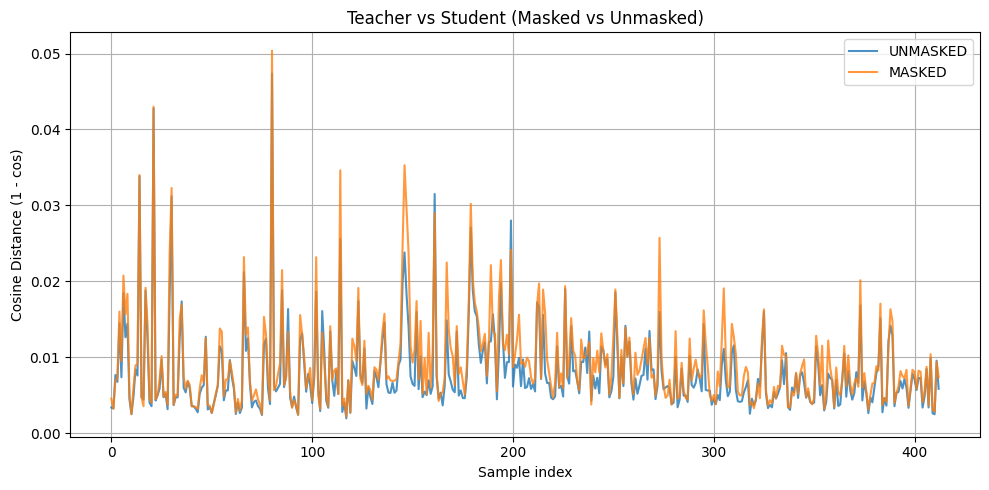

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# --- Your modules ---
from dataloader.idrid import IDRiDDataset
from models.retfound import RETFoundClassifier
from models.vmamba_backbone import VisualMamba
from config.constants import (
    IDRID_PATH, IMG_SIZE, PATCH_SIZE, IN_CHANS,
    VMAMBA_EMBED_DIM, VMAMBA_DEPTH,
    NUM_CLASSES, BATCH_SIZE,
    TEACHER_EMBED_DIM, MASK_RATIO
)

device = "cuda" if torch.cuda.is_available() else "cpu"

# ============================================================
# 1. TEACHER LOADER (RETFOUND)
# ============================================================

def load_teacher_from_ckpt(ckpt_path: str) -> RETFoundClassifier:
    print(f"[i] Loading RETFound teacher from ckpt: {ckpt_path}")

    ckpt = torch.load(ckpt_path, map_location="cpu")
    state = ckpt["state_dict"]

    teacher_full = RETFoundClassifier(num_classes=NUM_CLASSES)

    model_state = {}
    for k, v in state.items():
        if k.startswith("model."):
            model_state[k.replace("model.", "")] = v

    teacher_full.model.load_state_dict(model_state, strict=False)
    return teacher_full.eval().to(device)


# ============================================================
# 2. STUDENT + PROJECTOR LOADERS
# ============================================================

def build_student(mask_ratio: float) -> VisualMamba:
    student = VisualMamba(
        img_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        in_chans=IN_CHANS,
        embed_dim=VMAMBA_EMBED_DIM,
        depth=VMAMBA_DEPTH,
        learning_rate=0.0,
        mask_ratio=mask_ratio,
        use_cls_token=False,
    )
    return student


def build_projector():
    return nn.Sequential(
        nn.Linear(VMAMBA_EMBED_DIM, 2 * VMAMBA_EMBED_DIM),
        nn.GELU(),
        nn.Linear(2 * VMAMBA_EMBED_DIM, TEACHER_EMBED_DIM),
    )


def load_student_and_projector(student_ckpt, projector_ckpt, mask_ratio):
    print(f"[i] Loading student:   {student_ckpt}")
    print(f"[i] Loading projector: {projector_ckpt}")

    student = build_student(mask_ratio)
    projector = build_projector()

    s_ckpt = torch.load(student_ckpt, map_location="cpu")
    p_ckpt = torch.load(projector_ckpt, map_location="cpu")

    student.load_state_dict(s_ckpt["backbone"], strict=True)
    projector.load_state_dict(p_ckpt["projector"], strict=True)

    return student.eval().to(device), projector.eval().to(device)


# ============================================================
# 3. COMPUTE DISTANCE
# ============================================================

@torch.no_grad()
def compute_teacher_student_distance(teacher, student, projector, dataloader, apply_mask):
    distances = []

    for x, _, _ in dataloader:
        x = x.to(device)

        # ---- Student ----
        s = student.forward_features(
            x,
            return_pooled=True,
            apply_mask=apply_mask,
        )

        s = projector(s)

        # ---- Teacher ----
        t = teacher.forward_features(x, return_pooled=True)

        # ---- Distance ----
        cosine = F.cosine_similarity(s, t, dim=1)
        distances.extend((1 - cosine).cpu().tolist())

    return distances


# ============================================================
# 4. PLOT BOTH ON ONE FIGURE
# ============================================================

def plot_both(unmasked_dist, masked_dist, title="Teacher–Student Distance"):
    plt.figure(figsize=(10, 5))
    plt.plot(unmasked_dist, label="UNMASKED", alpha=0.8)
    plt.plot(masked_dist, label="MASKED", alpha=0.8)
    plt.xlabel("Sample index")
    plt.ylabel("Cosine Distance (1 - cos)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# 5. DATALOADER
# ============================================================

def build_idrid_loader():
    tfm = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])

    dataset = IDRiDDataset(
        root=IDRID_PATH,
        split="train",
        transform=tfm
    )

    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# ============================================================
# 6. MAIN
# ============================================================

if __name__ == "__main__":
    dataloader = build_idrid_loader()

    # ------------------- Load teacher -------------------
    teacher_ckpt = "retfound_linearprobe/lrjffdyi/checkpoints/retfound_linearprobe_best.ckpt"
    teacher = load_teacher_from_ckpt(teacher_ckpt)

    # ====================================================
    # FIRST PASS — UNMASKED
    # ====================================================
    s_path_un = "checkpoints/vmamba_distilled_student_UNMASKED.pth"
    p_path_un = "checkpoints/vmamba_distilled_projector_UNMASKED.pth"

    student_un, proj_un = load_student_and_projector(s_path_un, p_path_un, mask_ratio=0.0)

    print("\n[i] Computing UNMASKED distances...")
    dist_unmasked = compute_teacher_student_distance(
        teacher, student_un, proj_un, dataloader, apply_mask=False
    )

    # Free memory
    del student_un, proj_un
    torch.cuda.empty_cache()

    # ====================================================
    # SECOND PASS — MASKED
    # ====================================================
    s_path_m = "checkpoints/vmamba_distilled_student_MASKED.pth"
    p_path_m = "checkpoints/vmamba_distilled_projector_MASKED.pth"

    student_m, proj_m = load_student_and_projector(s_path_m, p_path_m, mask_ratio=MASK_RATIO)

    print("\n[i] Computing MASKED distances...")
    dist_masked = compute_teacher_student_distance(
        teacher, student_m, proj_m, dataloader, apply_mask=True
    )

    # Free memory
    del student_m, proj_m
    torch.cuda.empty_cache()

    # ====================================================
    # PLOT BOTH
    # ====================================================
    plot_both(dist_unmasked, dist_masked, "Teacher vs Student (Masked vs Unmasked)")


Original pivot:
model                 RETFound Finetuned  RETFound Linear Probing  \
dataset setting                                                     
APTOS   Finetuned                   0.21                      NaN   
        Linear Probe                 NaN                     0.25   
IDRID   Finetuned                   0.41                      NaN   
        Linear Probe                 NaN                     0.28   

model                 VMamba Masked  VMamba Unmasked  
dataset setting                                       
APTOS   Finetuned              0.15             0.06  
        Linear Probe           0.13             0.21  
IDRID   Finetuned              0.33             0.27  
        Linear Probe           0.31             0.34  

Bootstrapped pivot shape: (80, 4)
Fail to reject null hypothesis that data is normal for column RETFound Finetuned (p=nan>=0.012500)
Fail to reject null hypothesis that data is normal for column RETFound Linear Probing (p=nan>=0.012500)
R

<Figure size 1000x400 with 0 Axes>

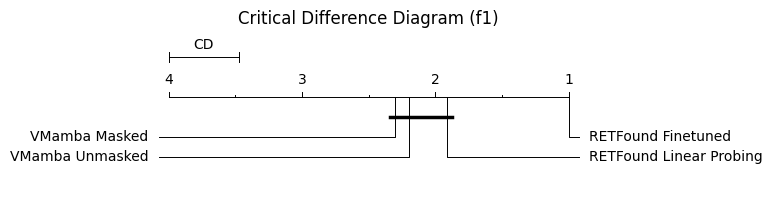

The statistical analysis was conducted for 4 populations with 80 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations VMamba Masked (p=0.000) and VMamba Unmasked (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=0.524 of the Nemenyi test.
We reject the null hypothesis (p=nan) of the Friedman 

TypeError: write() argument must be str, not None

In [ ]:
import pandas as pd
import numpy as np
from autorank import autorank, plot_stats, create_report
import matplotlib.pyplot as plt

csv_path = "results/results.csv"
df = pd.read_csv(csv_path)

metric = "f1"

pivot = df.pivot_table(
    index=["dataset","setting"],
    columns="model",
    values=metric
)

print("Original pivot:")
print(pivot)

# -------------------------------------------------------------
# Create bootstrap replications so autorank has >= 5 datasets
# -------------------------------------------------------------
N_BOOT = 20  # number of pseudo datasets

boot_pivot = []
for i in range(N_BOOT):
    sampled = pivot.sample(n=4, replace=True)  # bootstrap rows
    noise = np.random.normal(0, 1e-3, sampled.shape)  # tiny noise
    boot_pivot.append(sampled + noise)

boot_pivot = pd.concat(boot_pivot)
print("\nBootstrapped pivot shape:", boot_pivot.shape)

# -------------------------------------------------------------
# Run autorank
# -------------------------------------------------------------
results = autorank(
    boot_pivot,
    alpha=0.05,
    verbose=True
)

plt.figure(figsize=(10, 4))
plot_stats(results)
plt.title(f"Critical Difference Diagram ({metric})")
plt.show()

# Save report
with open("cd_report.txt", "w") as f:
    f.write(create_report(results))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Orange.evaluation.scoring import graph_ranks

csv_path = "results/results.csv"
df = pd.read_csv(csv_path)

metric = "f1"

pivot = df.pivot_table(
    index=["dataset","setting"],
    columns="model",
    values=metric
)

scores = pivot.to_numpy()
names = list(pivot.columns)

# Rank classifiers per task (higher = better)
ranks = np.argsort(np.argsort(-scores, axis=1), axis=1) + 1
avg_ranks = ranks.mean(axis=0)

cd = graph_ranks(avg_ranks, names, pivot.shape[0], alpha=0.05)
plt.title(f"Critical Difference Diagram ({metric})")
plt.show()


ImportError: cannot import name 'graph_ranks' from 'Orange.evaluation.scoring' (/home/andre/code/StudentMAE/.venv/lib/python3.12/site-packages/Orange/evaluation/scoring.py)

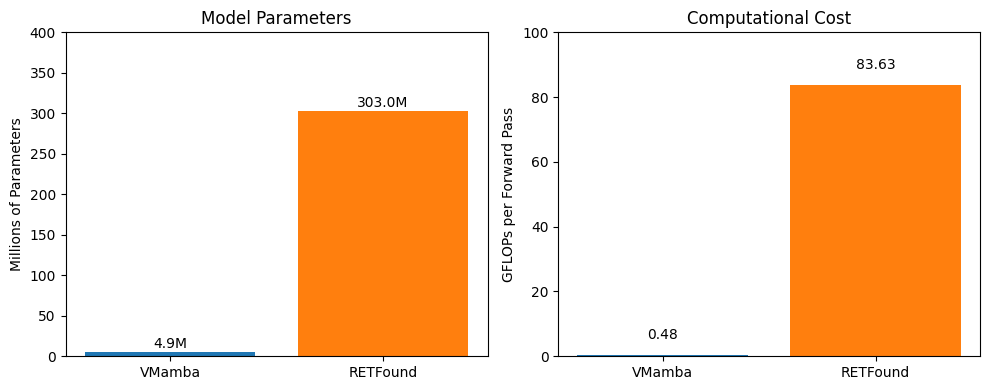

In [3]:
import matplotlib.pyplot as plt

# Data
models = ['VMamba', 'RETFound']
params = [4.9, 303]      # in millions
gflops = [0.48, 83.63]   # in GFLOPs

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Colors
param_colors = ['#1f77b4', '#ff7f0e']   # blue, orange
gflop_colors = ['#1f77b4', '#ff7f0e']   # blue, orange

# Parameters bar plot
axes[0].bar(models, params, color=param_colors)
axes[0].set_title('Model Parameters')
axes[0].set_ylabel('Millions of Parameters')
axes[0].set_ylim(0, 400)   # scale to 400

for i, v in enumerate(params):
    axes[0].text(i, v + 5, f'{v:.1f}M', ha='center')

# GFLOPs bar plot
axes[1].bar(models, gflops, color=gflop_colors)
axes[1].set_title('Computational Cost')
axes[1].set_ylabel('GFLOPs per Forward Pass')
axes[1].set_ylim(0, 100)   # scale to 400

for i, v in enumerate(gflops):
    axes[1].text(i, v + 5, f'{v:.2f}', ha='center')

plt.tight_layout()

# Save as PDF
plt.savefig("vmamba_retfound_complexity.pdf", dpi=300)

plt.show()


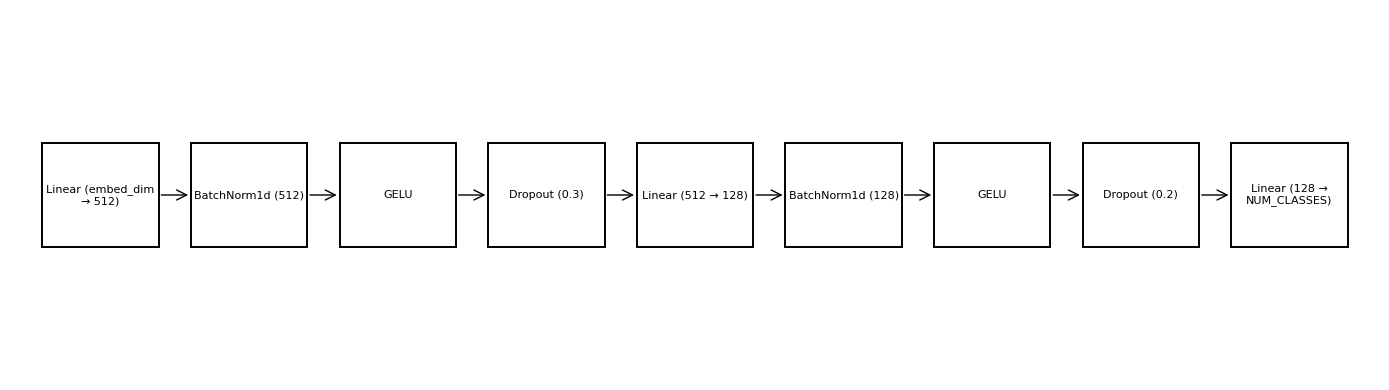

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import textwrap

fig, ax = plt.subplots(figsize=(14, 4))

layers = [
    "Linear (embed_dim → 512)",
    "BatchNorm1d (512)",
    "GELU",
    "Dropout (0.3)",
    "Linear (512 → 128)",
    "BatchNorm1d (128)",
    "GELU",
    "Dropout (0.2)",
    "Linear (128 → NUM_CLASSES)"
]

# Auto-wrap text to fit inside box
def wrap(text, width=16):
    return "\n".join(textwrap.wrap(text, width))

x_start = 0.05
y = 0.5
width = 0.18     # wider boxes
height = 0.28    # taller boxes
gap = 0.05       # more spacing

for i, layer in enumerate(layers):
    x = x_start + i * (width + gap)
    
    rect = Rectangle(
        (x, y - height/2), width, height,
        edgecolor='black', facecolor='none', linewidth=1.4
    )
    ax.add_patch(rect)

    wrapped = wrap(layer, width=18)

    ax.text(
        x + width/2, y, wrapped,
        ha='center', va='center', fontsize=8
    )
    
    if i < len(layers) - 1:
        arrow = FancyArrowPatch(
            (x + width, y),
            (x + width + gap, y),
            arrowstyle='->',
            mutation_scale=18
        )
        ax.add_patch(arrow)

ax.set_xlim(0, x_start + len(layers) * (width + gap))
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.savefig("classification_head_diagram_fixed.png", dpi=300, bbox_inches='tight')
plt.show()
